In [1]:
import os
import sys
### Wider Face dataset path
wider_face = '/kaggle/input/wider-face-a-face-detection-dataset'
### Append the modules directory to sys.path
sys.path.append('/kaggle/input/d/prashalruchiranga/modules')

In [2]:
import tensorflow as tf
### Enable eager execution
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')

tensorflow version: 2.16.1
keras version: 3.3.3


In [3]:
import os
import sys

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from math import ceil
import matplotlib.pyplot as plt
import json
from datetime import datetime
import shutil

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.object_detection_2d_geometric_ops import Resize

from misc_utils.utils import create_virtual_folder, format_labels

##### Define model configuration parameters

In [4]:
img_height = 512
img_width = 512
img_channels = 3
intensity_mean = 127.5  
intensity_range = 127.5 
n_classes = 1
min_scale = 0.07
max_scale = 0.9
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

##### Build the keras model

In [5]:
ssd = build_model(
    image_size=(img_height, img_width, img_channels),
    n_classes=n_classes,
    mode="training",
    l2_regularization=0.0005,
    min_scale=min_scale,
    max_scale=max_scale,
    aspect_ratios_global=aspect_ratios,
    aspect_ratios_per_layer=None,
    two_boxes_for_ar1=two_boxes_for_ar1,
    steps=steps,
    offsets=offsets,
    clip_boxes=clip_boxes,
    variances=variances,
    normalize_coords=normalize_coords,
    subtract_mean=intensity_mean,
    divide_by_stddev=intensity_range,
)

adam = Adam(learning_rate=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd.compile(optimizer=adam, loss=ssd_loss.compute_loss)

##### Set up the data generators

In [6]:
### Get current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

Current working directory: /kaggle/working


In [7]:
### Create symlinks to train-set
src_folder_train = os.path.join(wider_face, "WIDER_train/WIDER_train/images")
virtual_folder_train = os.path.join(cwd, "dataset/train/images")
create_virtual_folder(src_folder_train, virtual_folder_train)
### Format training set ground truth labels
train_labels_file = os.path.join(wider_face, "wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt")
formatted_train_labels_file = os.path.join(cwd, "dataset/train/train_bbox.csv")
format_labels(train_labels_file, formatted_train_labels_file)

'Formatted file succesfully saved to /kaggle/working/dataset/train/train_bbox.csv'

In [8]:
### Create symlinks to validation-set
src_folder_val = os.path.join(wider_face, "WIDER_val/WIDER_val/images")
virtual_folder_val = os.path.join(cwd, "dataset/val/images")
logs = create_virtual_folder(src_folder_val, virtual_folder_val)
### Format validation set ground truth labels
val_labels_file = os.path.join(wider_face, "wider_face_annotations/wider_face_split/wider_face_val_bbx_gt.txt")
formatted_val_labels_file = os.path.join(cwd, "dataset/val/val_bbox.csv")
format_labels(val_labels_file, formatted_val_labels_file)

'Formatted file succesfully saved to /kaggle/working/dataset/val/val_bbox.csv'

In [9]:
### Instantiate data generators
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

### Images
images_train = virtual_folder_train
images_val = virtual_folder_val

### Ground truth
labels_train = formatted_train_labels_file
labels_val = formatted_val_labels_file

train_dataset.parse_csv(
    images_dir=images_train,
    labels_filename=labels_train,
    input_format=["image_name", "xmin", "xmax", "ymin", "ymax", "class_id"],
    ### There are 4 images with only background in the train set. Their class id is set to 0. Therefore only include class id 1 (face).
    include_classes=[1],
)

val_dataset.parse_csv(
    images_dir=images_val,
    labels_filename=labels_val,
    input_format=["image_name", "xmin", "xmax", "ymin", "ymax", "class_id"],
    include_classes=[1],
)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()

print(f"Number of images in the training dataset: {train_dataset_size}")
print(f"Number of images in the validation dataset: {val_dataset_size}")

Number of images in the training dataset: 12876
Number of images in the validation dataset: 3226


In [10]:
batch_size = 16

resize = Resize(height=img_height, width=img_width)

predictor_sizes = [ssd.get_layer('classes4').output.shape[1:3],
                   ssd.get_layer('classes5').output.shape[1:3],
                   ssd.get_layer('classes6').output.shape[1:3],
                   ssd.get_layer('classes7').output.shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    min_scale=min_scale,
                                    max_scale=max_scale,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images', 'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images', 'encoded_labels'},
                                     keep_images_without_gt=False)

##### Train the model

In [11]:
### Create directories to save model checkpoints and csv loggers
os.makedirs(name='/kaggle/working/tmp/checkpoints', exist_ok=True)
os.makedirs(name='/kaggle/working/tmp/runs', exist_ok=True)

In [12]:
### Define model callbacks
model_checkpoint = ModelCheckpoint(filepath='/kaggle/working/tmp/checkpoints/ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.keras',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch')

csv_logger = CSVLogger(filename='/kaggle/working/tmp/runs/ssd_7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=5,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint, 
             csv_logger, 
             early_stopping, 
             reduce_learning_rate]

In [13]:
initial_epoch = 0
final_epoch = 30
steps_per_epoch = ceil(train_dataset_size/batch_size)

history = ssd.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=final_epoch,
                  callbacks=callbacks,
                  validation_data=val_generator,
                  validation_steps=ceil(val_dataset_size/batch_size),
                  initial_epoch=initial_epoch)  

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0766
Epoch 1: val_loss improved from inf to 3.18396, saving model to /kaggle/working/tmp/checkpoints/ssd7_epoch-01_loss-3.3002_val_loss-3.1840.keras
805/805 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - loss: 4.0756 - val_loss: 3.1840 - learning_rate: 0.0010
Epoch 2/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.9117
Epoch 2: val_loss improved from 3.18396 to 2.72997, saving model to /kaggle/working/tmp/checkpoints/ssd7_epoch-02_loss-2.8436_val_loss-2.7300.keras
805/805 ━━━━━━━━━━━━━━━━━━━━ 1100s 1s/step - loss: 2.9116 - val_loss: 2.7300 - learning_rate: 0.0010
Epoch 3/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.7498
Epoch 3: val_loss did not improve from 2.72997
805/805 ━━━━━━━━━━━━━━━━━━━━ 1111s 1s/step - loss: 2.7498 - val_loss: 2.8677 - learning_rate: 0.0010
Epoch 4/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.6795
Epoch 4: val_loss improved from 2.72997 to 2.56565, saving model to /kaggle/working/tmp/checkpoints/ssd7_

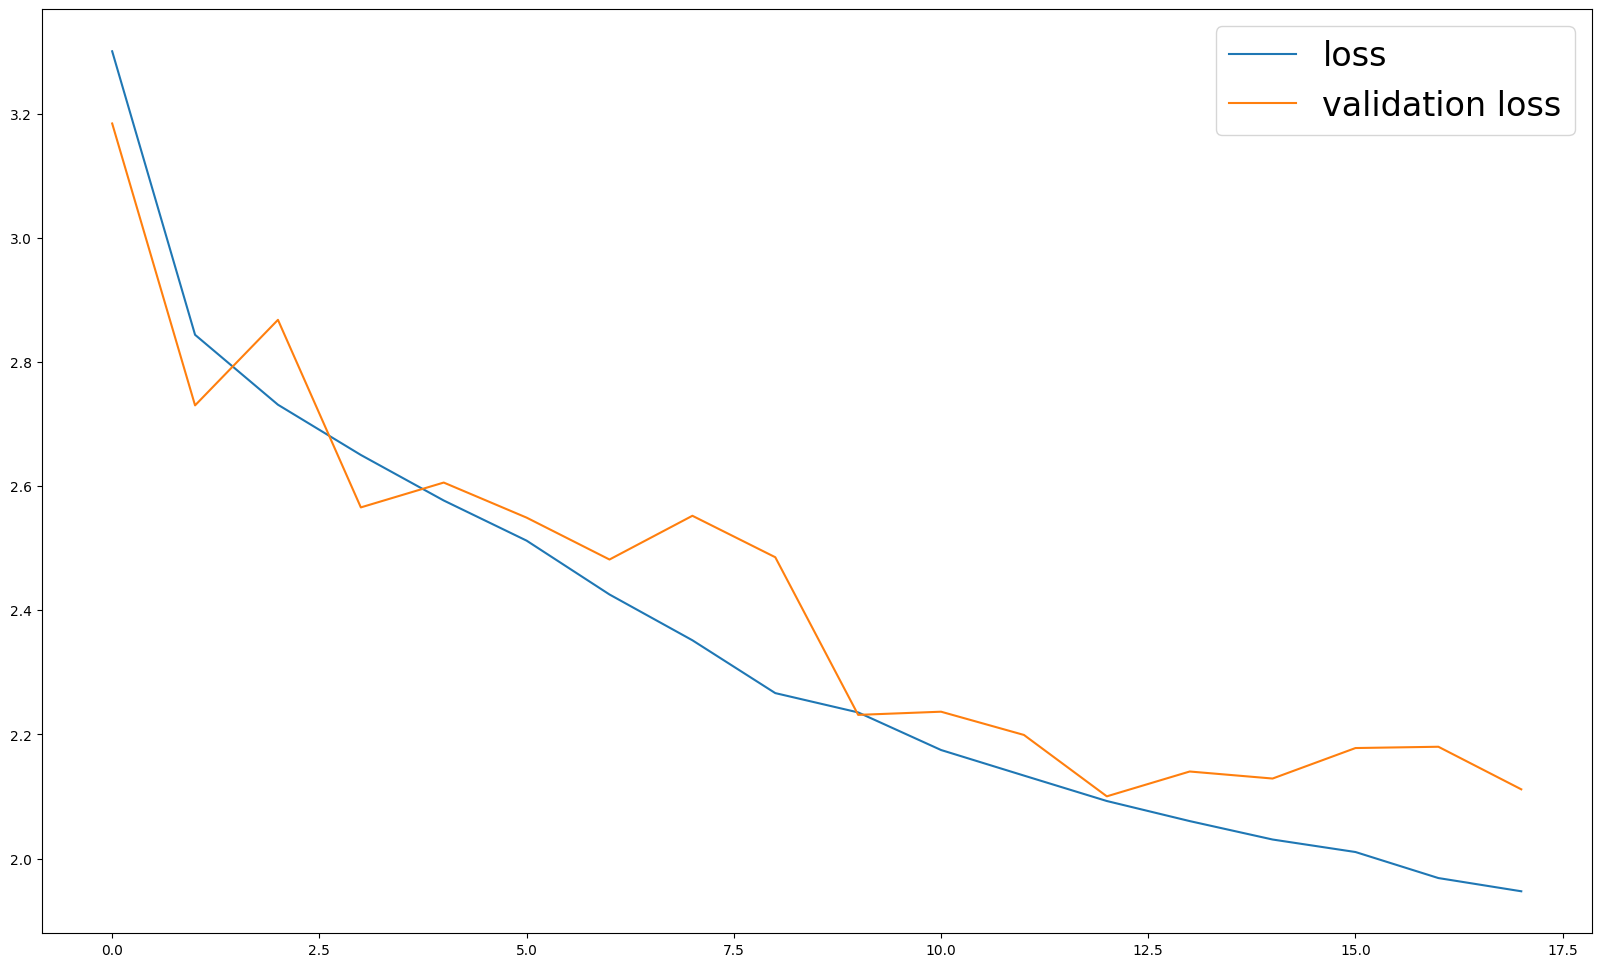

In [14]:
### Plot training curves

plt.figure(figsize=(20, 12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='upper right', prop={'size':24})
plt.show()

In [15]:
### Save the history object in JSON format

history_dict = history.history
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d %H:%M:%S")

with open(f'/kaggle/working/tmp/runs/history {timestamp}.json', 'w') as f:
    json.dump(history_dict, f)

In [16]:
### Compress the model folder or file

shutil.make_archive('/kaggle/working/tmp', 'zip', '/kaggle/working/', 'tmp')

'/kaggle/working/tmp.zip'